In [1]:
from ay_torch import *
import os

In [2]:
class TPPX2Dataset(torch.utils.data.Dataset):
  def __init__(self, root=f'{os.environ["HOME"]}/data/neville/ppx2/', classes=('salmon','tuna','label','side'),
               transform=None, mode='train', test_ratio=0.2, split_seed=42):
    self.transform= transform
    self.image_paths= []
    self.classes= classes
    self.root= root
    self.mode= mode
    self.test_ratio= test_ratio
    self.split_seed= split_seed
    self.MakePathLabelList()

  def MakePathLabelList(self):
    self.image_paths= []
    self.labels= []
    for i_cls,cls in enumerate(self.classes):
      dirname= os.path.join(self.root, cls)
      filenames= [filename for filename in os.listdir(dirname) if filename.endswith('.png')]
      idxes= np.random.RandomState(seed=self.split_seed).permutation(len(filenames))
      n_train= round(len(filenames)*(1.-self.test_ratio))
      print(f'Found {len(filenames)} files in {dirname}, for train: {n_train}, for test: {len(filenames)-n_train}')
      image_paths= [os.path.join(dirname, filenames[idx]) for idx in (idxes[:n_train] if self.mode=='train' else idxes[n_train:])]
      self.image_paths+= image_paths
      self.labels+= [i_cls]*len(image_paths)

  def __getitem__(self, index):
    with open(self.image_paths[index],'rb') as f:
      img= PILImage.open(f)
      img= img.convert('RGB')
    img= img if self.transform is None else self.transform(img)
    # tr_value= lambda v: torch.autograd.Variable(torch.tensor([v]))
    return img, self.labels[index]

  def __len__(self):
    return len(self.image_paths)

In [3]:
def GetDataTransforms(mode):
  if mode=='train':
    return torchvision.transforms.Compose([
        # torchvision.transforms.Resize(224),
        torchvision.transforms.Resize((460,460)),
        torchvision.transforms.Pad(20, padding_mode='constant'),  #'reflect'
        # torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomAffine(degrees=10, scale=(1.,1.1), shear=(-0.2,0.2,-0.2,0.2)),
        torchvision.transforms.CenterCrop(460),
        torchvision.transforms.RandomResizedCrop(224, scale=(0.75,1.), ratio=(1.,1.)),
        torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0, hue=0),
        torchvision.transforms.ToTensor(),
      ])
  if mode=='test':
    return torchvision.transforms.Compose([
        # torchvision.transforms.Resize(256),
        # torchvision.transforms.CenterCrop(224),
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.ToTensor(),
      ])
  if mode=='none':
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(224),
        torchvision.transforms.ToTensor()
      ])

In [4]:
dset_train= TPPX2Dataset(transform=GetDataTransforms('train'), mode='train')
dset_test= TPPX2Dataset(transform=GetDataTransforms('test'), mode='test')

#NOTE: Adjust the batch size.
n_batch= 10
dl_train= torch.utils.data.DataLoader(
              dataset=dset_train,
              batch_size=n_batch,
              shuffle=True,
              num_workers=2)
dl_test= torch.utils.data.DataLoader(
              dataset=dset_test,
              batch_size=n_batch,
              shuffle=False,
              num_workers=2)

Found 134 files in /home/akihikoy/data/neville/ppx2/salmon, for train: 107, for test: 27
Found 138 files in /home/akihikoy/data/neville/ppx2/tuna, for train: 110, for test: 28
Found 280 files in /home/akihikoy/data/neville/ppx2/label, for train: 224, for test: 56
Found 111 files in /home/akihikoy/data/neville/ppx2/side, for train: 89, for test: 22
Found 134 files in /home/akihikoy/data/neville/ppx2/salmon, for train: 107, for test: 27
Found 138 files in /home/akihikoy/data/neville/ppx2/tuna, for train: 110, for test: 28
Found 280 files in /home/akihikoy/data/neville/ppx2/label, for train: 224, for test: 56
Found 111 files in /home/akihikoy/data/neville/ppx2/side, for train: 89, for test: 22


In [5]:
print('dset_train size:',len(dset_train))
print('dset_train[0] input type, shape:',type(dset_train[0][0]),dset_train[0][0].shape)
print('dset_train[0] label value:',dset_train[0][1],type(dset_train[0][1]),dset_train.classes[dset_train[0][1]])
print('dset_train[0][0] value range:',torch.min(dset_train[0][0]),torch.max(dset_train[0][0]))
print('dset_test size:',len(dset_test))
print('dset_test[0] input type, shape:',type(dset_test[0][0]),dset_test[0][0].shape)
print('dset_test[0] label value:',dset_test[0][1],dset_test.classes[dset_test[0][1]])

dset_train size: 530
dset_train[0] input type, shape: <class 'torch.Tensor'> torch.Size([3, 224, 224])
dset_train[0] label value: 0 <class 'int'> salmon
dset_train[0][0] value range: tensor(0.1804) tensor(0.9686)
dset_test size: 133
dset_test[0] input type, shape: <class 'torch.Tensor'> torch.Size([3, 224, 224])
dset_test[0] label value: 0 salmon


Data proc time: 0.13066458702087402


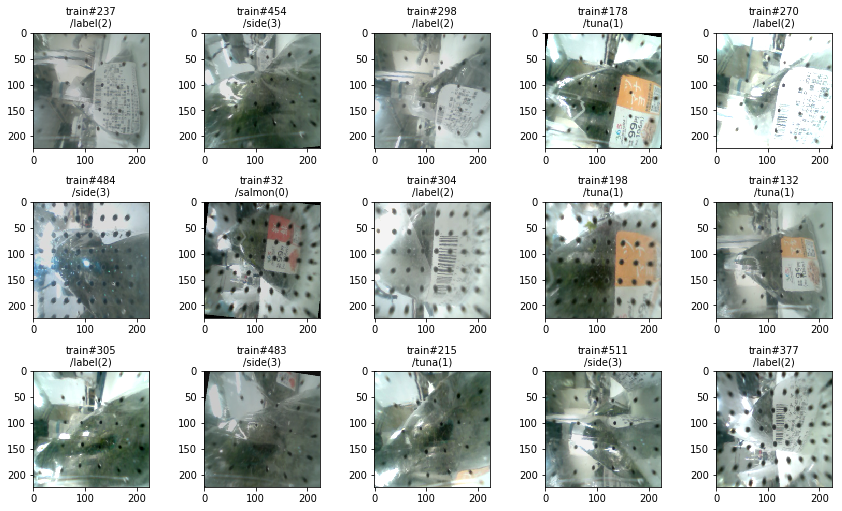

In [6]:
d= dset_train
idxes= np.random.permutation(len(d))[:15]
t0= time.time()
imgs= [d[i][0] for i in idxes]
print(f'Data proc time: {time.time()-t0}')
labels= [f'train#{i}\n/{d.classes[d[i][1]]}({d[i][1]})' for i in idxes]
PlotImgGrid(imgs, labels)

## ResNet-18 with pretrained network parameters

In [7]:
#Setup a neural network.
net= TResNet18(in_channels=3, out_channels=len(dset_train.classes))

#Load pretrained model parameters.
url= 'https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth'
net.load_state_dict(torchvision.models.utils.load_state_dict_from_url(url, map_location='cpu')['model'], strict=False)

device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
# f_loss= torch.nn.MSELoss()
f_loss= torch.nn.CrossEntropyLoss()

def decode(pred):
  return pred.max(1).indices

def accuracy(y,y_trg):
  return (decode(y)==y_trg).sum().item()/len(y_trg)
f_metric= accuracy

def tfm_batch(batch):
  x,y= batch
  return x,y
logger= TLogger()
disp= TDisp()

In [8]:
LoadStateDict('model_learned/resnet_ppx2.pt', net=net, opt=opt, device=device)
# net.to(device)
# LoadStateDict(tmp_states, net=net, opt=opt, device=device)

In [9]:
input_size= (1,)+dset_train[0][0].shape
print(f'input_size={input_size}')
torchinfo.summary(net, input_size)

input_size=(1, 3, 224, 224)


/home/akihikoy/.local/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                        Output Shape              Param #
TResNet                                       --                        --
├─Sequential: 1-1                             [1, 32, 224, 224]         --
│    └─Conv2d: 2-1                            [1, 32, 224, 224]         864
│    └─BatchNorm2d: 2-2                       [1, 32, 224, 224]         64
│    └─ReLU: 2-3                              [1, 32, 224, 224]         --
├─Sequential: 1-2                             [1, 32, 112, 112]         --
│    └─Conv2d: 2-4                            [1, 32, 112, 112]         9,216
│    └─BatchNorm2d: 2-5                       [1, 32, 112, 112]         64
│    └─ReLU: 2-6                              [1, 32, 112, 112]         --
├─Sequential: 1-3                             [1, 64, 56, 56]           --
│    └─Conv2d: 2-7                            [1, 64, 56, 56]           18,432
│    └─BatchNorm2d: 2-8                       [1, 64, 56, 56]           128
│    └─ReLU

In [10]:
# states= torch.load('model_learned/resnet_ppx2.pt', map_location=device)
# [p.device for p in net.parameters()]
# [p.device for p in opt.param_groups[0]['params']]
# [type(opt.param_groups[0][key]) for key in ('lr', 'betas', 'eps', 'weight_decay', 'amsgrad')]
# states={}
# SaveStateDict(states, net=net, opt=opt)
# states

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


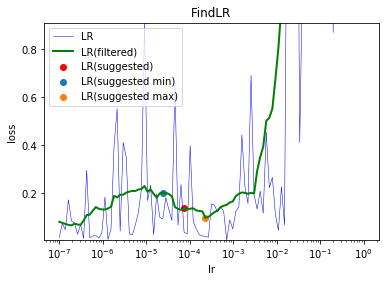

lr= 7.413102413009172e-05, lr_min=2.3988329190194914e-05, lr_max=0.00022908676527677726


In [11]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(test)	time
13	0.15413561	0.11298019	0.97142857	2.710629


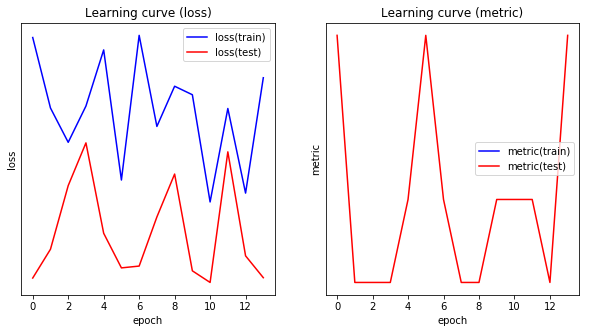

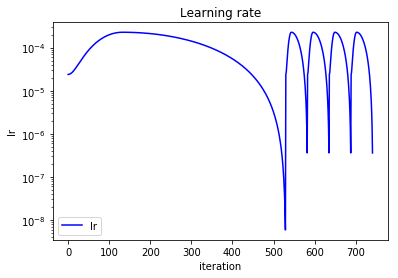

In [16]:
FitOneCycle(net, n_epoch=1, lr_max=lr_max, div_init=lr_max/lr_min, 
    opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()
logger.PlotLR()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
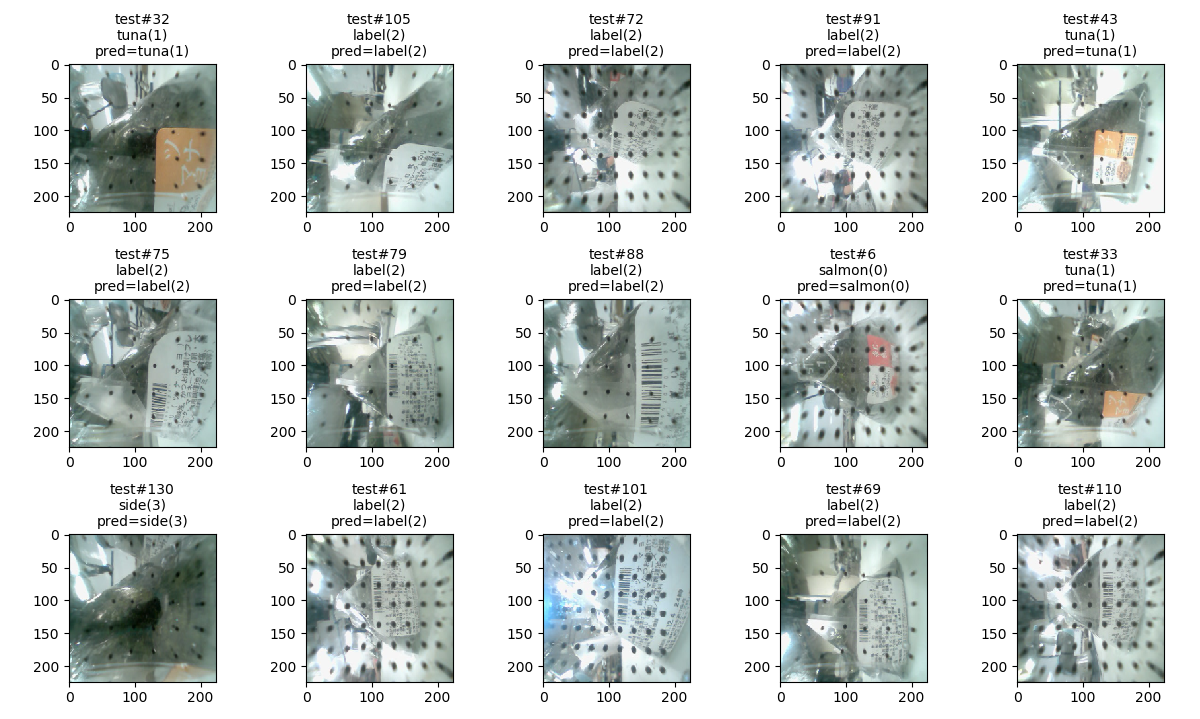

In [17]:
%matplotlib widget
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
pred= decode(Eval(net,imgs,device=device)).cpu()
labels= [f'test#{i}\n{d.classes[d[i][1]]}({d[i][1]})\npred={d.classes[lp]}({lp})' for i,lp in zip(idxes,pred)]
PlotImgGrid(imgs, labels)

In [18]:
SaveStateDict('model_learned/resnet_ppx2.pt', net=net, opt=opt)
# tmp_states= {}
# SaveStateDict(tmp_states, net=net, opt=opt)